In [1]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.read_excel('../movies.xlsx', index_col=0)
titles = df.index.tolist()


In [3]:
omdb_df = pd.read_json('omdb_data.json')
omdb_df = omdb_df.set_index("Title")


In [4]:
trend_df = pd.read_json("./trends_data.json", orient='table')

In [5]:
# Compute metrics for trend_df


avg_df = trend_df.groupby(level=0).mean()
std_df = trend_df.groupby(level=0).std()
max_df = trend_df.groupby(level=0).max()
min_df = trend_df.groupby(level=0).min()

std_df.head()

,searches,isPartial
A Hidden Life,17.809955,0.0
A Quiet Place,16.098994,0.0
Alpha,7.996700,0.0
Anthropoid,20.396707,0.0
Ashby,8.386656,0.0


In [6]:
# Merge

df1 = omdb_df.copy()
df1 = df1.merge(avg_df['searches'], how='left', left_index=True, right_index=True)
df1 = df1.rename(columns={"searches": "searches_avg"})
df1 = df1.merge(std_df['searches'], how='left', left_index=True, right_index=True)
df1 = df1.rename(columns={"searches": "searches_std"})
df1 = df1.merge(max_df['searches'], how='left', left_index=True, right_index=True)
df1 = df1.rename(columns={"searches": "searches_max"})
df1 = df1.merge(min_df['searches'], how='left', left_index=True, right_index=True)
df1 = df1.rename(columns={"searches": "searches_min"})

In [7]:
# Flatten ratings

df2 = df1.copy()

df2 = df2.replace("N/A", pd.NA)

def flatten_ratings(row):
    x = {s["Source"]: s["Value"] for s in row['Ratings']}
    # Not needed
#     if 'Internet Movie Database' in x:
#         row['Internet Movie Database'] = float(x['Internet Movie Database'].split("/")[0]) / 10
#     else:
#         row['Internet Movie Database'] = np.NaN
    
    if 'Rotten Tomatoes' in x:
        row['Rotten Tomatoes'] = float(x['Rotten Tomatoes'][:-1]) / 100
    else:
        row['Rotten Tomatoes'] = np.NaN
                                      
    if 'Metacritic' in x:
        row['Metacritic'] = float(x['Metacritic'].split("/")[0]) / 100
    else:
        row['Metacritic'] = np.NaN
    
    return row

df2 = df2.apply(flatten_ratings, axis = 1)

In [8]:
# Process numerical data

df2['Runtime'] = df2['Runtime'].apply(lambda x: int(x.split()[0]) if x is not pd.NA else np.NaN)
df2['imdbVotes'] = df2['imdbVotes'].apply(lambda x: int( x.replace(",", "")) if x is not pd.NA else np.NaN)
df2['BoxOffice'] = df2['BoxOffice'].apply(lambda x: int( x.replace(",", "")[1:]) if x is not pd.NA else np.NaN)
df2['Metascore'] = df2['Metascore'].apply(lambda x: int(x) if x is not pd.NA else np.NaN)


In [9]:
df2['Metascore'].dtypes

dtype('float64')

In [10]:
# Process datetime data

df2['Year'] = pd.to_datetime(df2["Year"])
df2['Released'] = pd.to_datetime(df2['Released'])
df2['DVD']= pd.to_datetime(df2['DVD'])

In [11]:
# Clean data

df3 = df2.copy()
df3.isnull().sum(axis=0)

Year                 0
Rated                3
Released             0
Runtime              0
Genre                0
Director             0
Writer               0
Actors               0
Plot                 0
Language             1
Country              0
Awards              22
Poster               0
Ratings              0
Metascore           18
imdbRating           0
imdbVotes            0
imdbID               0
Type                 0
DVD                  5
BoxOffice           35
Production         111
Website            150
Response             0
searches_avg        45
searches_std        45
searches_max        45
searches_min        45
Rotten Tomatoes     10
Metacritic          18
dtype: int64

<AxesSubplot:ylabel='Title'>

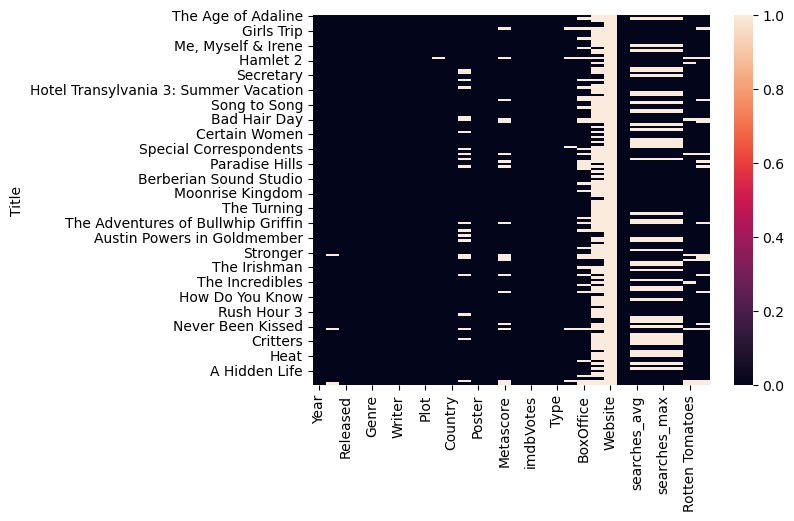

In [12]:
sns.heatmap(df3.isnull())

In [14]:
# drop columns with more than 50% null values

threshold = 0.5
df3 = df3.dropna(thresh=len(df3) * threshold, axis=1)

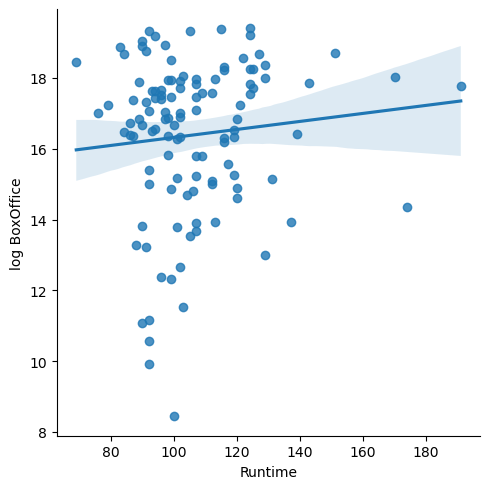

In [98]:
df4 = df3.copy()
df4['log BoxOffice'] = np.log(df4["BoxOffice"])
df4["1/Runtime"] = 1 / df4["Runtime"]
df4["Runtime ** 0.5"] = np.sqrt(df4["Runtime"])
df4["log Runtime"] = np.log(df4["Runtime"])
sns.lmplot(x="Runtime", y="BoxOffice", data=df4, logx=False);

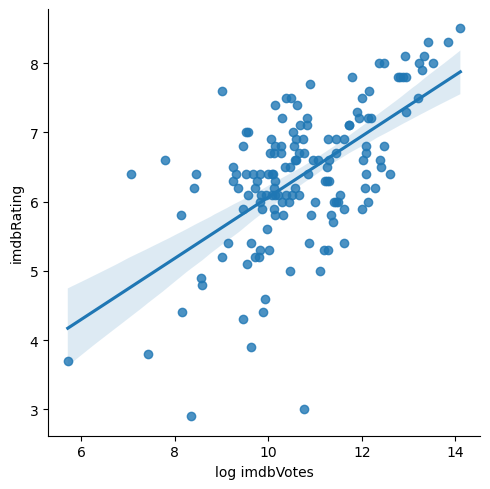

In [100]:
df4["log imdbVotes"] = np.log(df4["imdbVotes"])
df4["log imdbRating"] = np.log(df4["imdbRating"])
sns.lmplot(x="log imdbVotes", y="imdbRating", data=df4, logx=False);

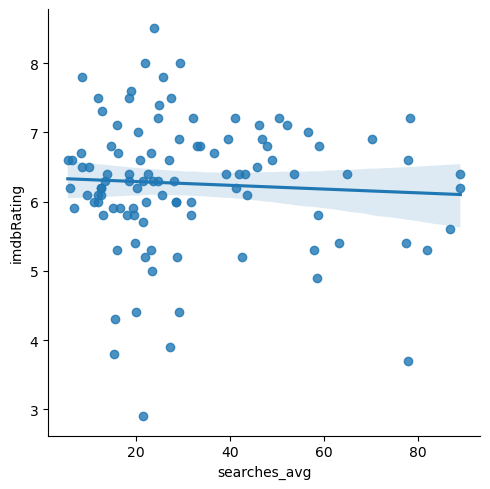

In [112]:
df4["log searches_avg"] = np.log(df4["searches_avg"])
sns.lmplot(x="searches_avg", y="imdbRating", data=df4, logx=False);

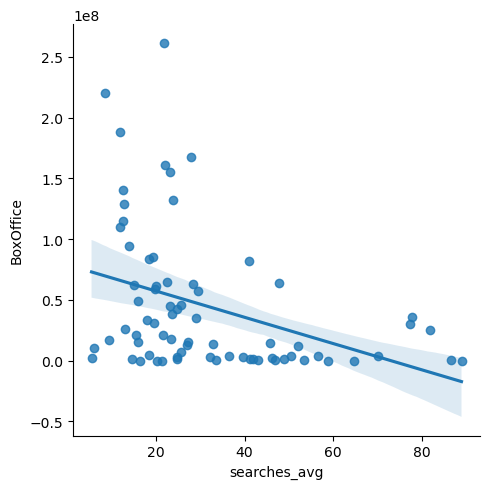

In [110]:
sns.lmplot(x="searches_avg", y="BoxOffice", data=df4, logx=False);

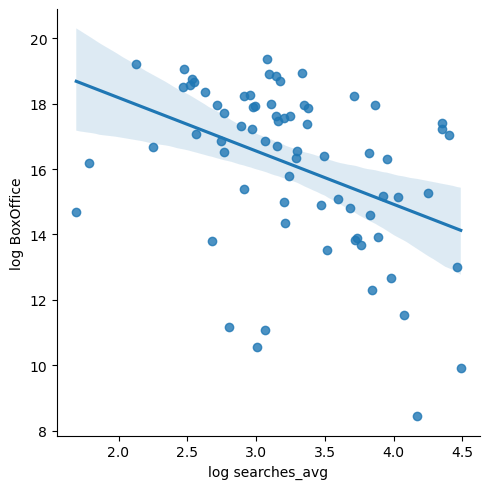

In [116]:
sns.lmplot(x="log searches_avg", y="log BoxOffice", data=df4, logx=False);

In [113]:
df4.corr()

/var/folders/80/9k30qm0x143dm5hn3w1wtzzm0000gn/T/ipykernel_3601/3006967730.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df4.corr()


,Runtime,Metascore,imdbRating,imdbVotes,BoxOffice,searches_avg,searches_std,searches_max,searches_min,Rotten Tomatoes,Metacritic,log BoxOffice,1/Runtime,Runtime ** 0.5,log Runtime,log imdbVotes,log imdbRating,log searches_avg
Runtime,1.000000,0.258102,0.262314,0.315073,0.047923,0.042636,-0.058064,NaN,0.055128,0.194633,0.258102,0.097298,-0.650348,0.979188,0.901374,0.335813,0.234168,-0.009323
Metascore,0.258102,1.000000,0.784951,0.412566,0.156426,-0.042435,0.087561,NaN,-0.071043,0.914302,1.000000,-0.020668,-0.205327,0.248077,0.235731,0.442284,0.756760,0.001214
imdbRating,0.262314,0.784951,1.000000,0.548013,0.256251,-0.060178,0.144154,NaN,-0.097347,0.739783,0.784951,0.051826,0.013513,0.207643,0.130531,0.611553,0.987443,-0.044559
imdbVotes,0.315073,0.412566,0.548013,1.000000,0.550566,-0.172731,0.147507,NaN,-0.157868,0.312540,0.412566,0.382968,-0.131195,0.286632,0.238578,0.740561,0.475553,-0.138006
BoxOffice,0.047923,0.156426,0.256251,0.550566,1.000000,-0.372692,0.203027,NaN,-0.297265,0.095370,0.156426,0.683195,-0.032018,0.045501,0.041973,0.633423,0.233307,-0.381205
searches_avg,0.042636,-0.042435,-0.060178,-0.172731,-0.372692,1.000000,-0.520379,NaN,0.932616,-0.044913,-0.042435,-0.439477,-0.088545,0.066125,0.082707,-0.260388,-0.052636,0.938260
searches_std,-0.058064,0.087561,0.144154,0.147507,0.203027,-0.520379,1.000000,NaN,-0.753826,0.037000,0.087561,0.283843,0.112970,-0.077651,-0.095306,0.200161,0.126426,-0.326621
searches_max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
searches_min,0.055128,-0.071043,-0.097347,-0.157868,-0.297265,0.932616,-0.753826,NaN,1.000000,-0.059824,-0.071043,-0.366822,-0.097065,0.077223,0.092592,-0.238560,-0.085150,0.808546
Rotten Tomatoes,0.194633,0.914302,0.739783,0.312540,0.095370,-0.044913,0.037000,NaN,-0.059824,1.000000,0.914302,-0.072031,-0.152670,0.186831,0.177066,0.327143,0.714429,-0.020944


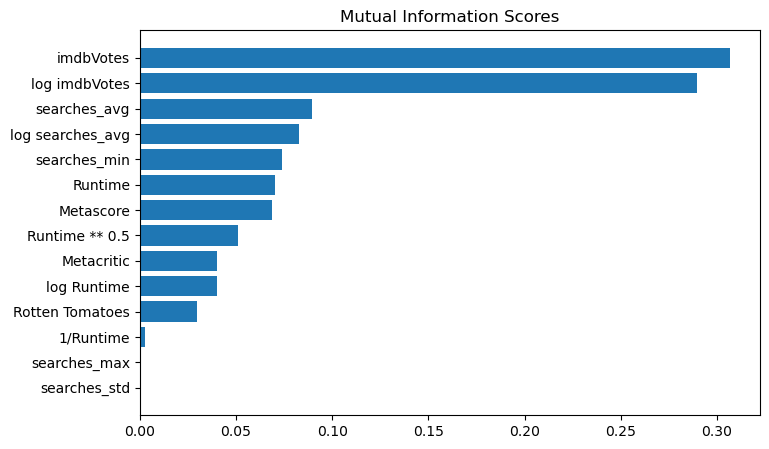

In [123]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

X = df4.copy()
X['BoxOffice'] = X['BoxOffice'].dropna()
X['imdbRating'] = X['imdbRating'].dropna()

y1 = X.pop('BoxOffice')
y2 = X.pop('imdbRating')
X.pop('log BoxOffice')
X.pop('log imdbRating')
X = X.select_dtypes(include=["float64", "int64"])
X = X.fillna(X.mean())
y1 = y1.fillna(y1.mean())
y2 = y2.fillna(y2.mean())
mi_scores1 = make_mi_scores(X, y1)
mi_scores2 = make_mi_scores(X, y2)

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores1)


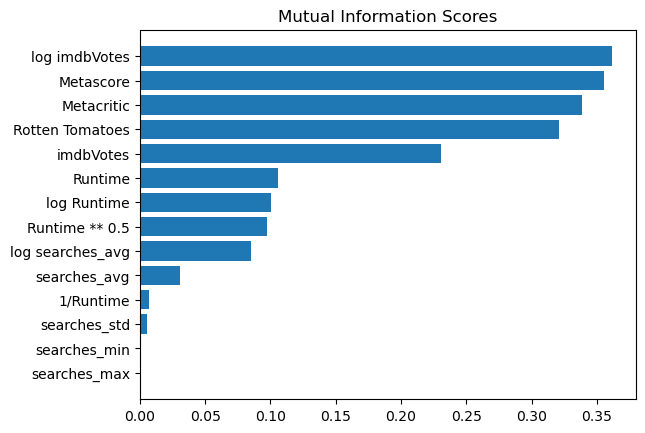

In [124]:
plot_mi_scores(mi_scores2)

<AxesSubplot:>

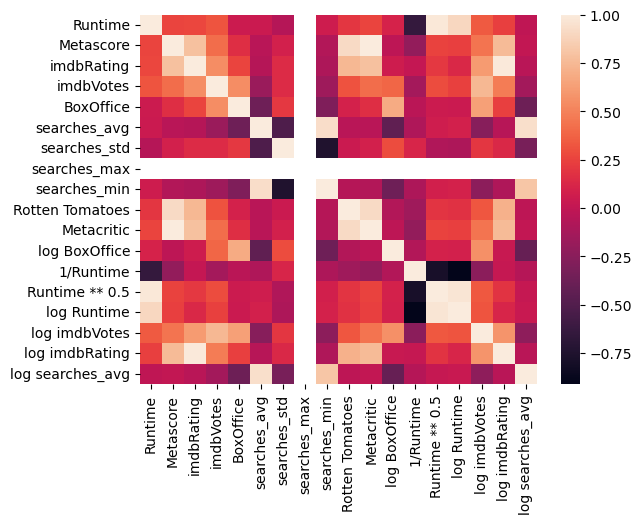

In [126]:
corr = df4.select_dtypes(include=["float64", "int64"]).corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

<AxesSubplot:>

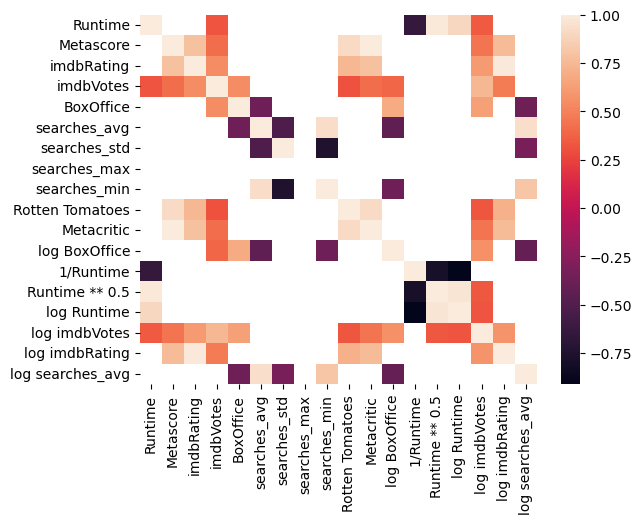

In [135]:
 # Get categorical and numerical features
corr = df4.select_dtypes(include=["float64", "int64"]).corr()
corr = corr[abs(corr) > 0.3]
# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [129]:
# What about Director, Writer, Actors, Country
df15 = df3[["Director", "Writer", "Actors", "Country"]]
df_t = df_numeric['BoxOffice'].dropna()
df15 = df15.merge(df_t, how='inner', left_index=True, right_index=True)
print(len(df15["Director"].dropna().unique()))

def get_unique(arr, df, key):
    arr = set(arr)
    for d in df[key].dropna().unique():
        t = d.split(",")
        new = set([a.strip() for a in t])
        arr = arr.union(new)
    return list(arr)
    
directors = []
directors = get_unique(directors, df15, 'Director')
print(len(directors))

writers = []
writers = get_unique(writers, df15, 'Writer')
print(len(writers))

actors = []
actors = get_unique(actors, df15, 'Actors')
print(len(actors))

countries = []
countries = get_unique(countries, df15, 'Country')
print(len(countries))


NameError: name 'df_numeric' is not defined

In [296]:
def plot_cat(df, cats, x, y="BoxOffice"):
    df1 = pd.DataFrame(df[y].copy())
    df1 = df1.dropna()
    for c in cats:
        df1[c] = df[x].apply(lambda x: int(c in x))
        sns.catplot(data=df1, x=c, y=y, kind="box")
        plt.savefig(f"./{x}/{y}, {c}.png")
        plt.close()
plot_cat(df15, directors, "Director")

In [297]:
plot_cat(df15, countries, "Country")

In [298]:
plot_cat(df15, actors, "Actors")

In [16]:
# Drop irrelvant features for now
df4 = df3.copy()
cols_to_drop = ["Director", "Actors", "Plot", "Language", "Country", "Awards", "Poster", "Ratings", "Response", "imdbID", "Type", "Writer"]
df4 = df4.drop(cols_to_drop, axis=1)
df4.dtypes

Year               datetime64[ns]
Rated                      object
Released           datetime64[ns]
Runtime                     int64
Genre                      object
Metascore                 float64
imdbRating                float64
imdbVotes                   int64
DVD                datetime64[ns]
BoxOffice                 float64
searches_avg              float64
searches_std              float64
searches_max              float64
searches_min              float64
Rotten Tomatoes           float64
Metacritic                float64
dtype: object

In [196]:
# Extract numeric and categorical variables

df5 = df4.copy()

for colname in df5.select_dtypes("object"):
    df5[colname].factorize()

df5.tail(20)

,Year,Rated,Released,Runtime,Genre,Metascore,imdbRating,imdbVotes,DVD,BoxOffice,searches_avg,searches_std,searches_max,searches_min,Rotten Tomatoes,Metacritic
Title,,,,,,,,,,,,,,,,
Ferris Bueller's Day Off,1970-01-01 00:00:00.000001986,PG-13,1986-06-11,103,Comedy,61.0,7.8,364690,1999-10-19,70136369.0,NaN,NaN,NaN,NaN,0.81,0.61
Spies Like Us,1970-01-01 00:00:00.000001985,PG,1985-12-06,102,"Adventure, Comedy",22.0,6.4,50951,1998-11-10,60106536.0,NaN,NaN,NaN,NaN,0.32,0.22
Critters,1970-01-01 00:00:00.000001986,PG-13,1986-04-11,86,"Comedy, Horror, Sci-Fi",52.0,6.1,36670,2003-08-05,13167232.0,NaN,NaN,NaN,NaN,0.50,0.52
Reservoir Dogs,1970-01-01 00:00:00.000001992,R,1992-09-02,99,"Crime, Thriller",79.0,8.3,1030264,2003-03-18,2832029.0,NaN,NaN,NaN,NaN,0.90,0.79
Good Kill,1970-01-01 00:00:00.000002014,R,2015-05-15,102,"Drama, Thriller, War",63.0,6.4,24332,2015-08-25,316472.0,53.509434,15.528662,100.0,36.0,0.76,0.63
Semi-Pro,1970-01-01 00:00:00.000002008,R,2008-02-29,91,"Comedy, Sport",47.0,5.8,83766,2008-06-03,33479698.0,17.942308,18.827820,100.0,3.0,0.22,0.47
Searching for Bobby Fischer,1970-01-01 00:00:00.000001993,PG,1993-08-11,109,"Biography, Drama, Sport",89.0,7.4,40906,2013-11-12,7266383.0,NaN,NaN,NaN,NaN,1.00,0.89
Night of the Living Dead,1970-01-01 00:00:00.000001968,Not Rated,1968-10-04,96,"Horror, Thriller",89.0,7.8,132066,2001-03-01,236452.0,NaN,NaN,NaN,NaN,0.96,0.89
Heat,1970-01-01 00:00:00.000001995,R,1995-12-15,170,"Action, Crime, Drama",76.0,8.3,664234,1999-07-27,67436818.0,NaN,NaN,NaN,NaN,0.88,0.76


In [216]:
# Get all possible genres and rated
genres = set()
rated = set()

for genre in df5['Genre']:
    t = genre.split(",")
    new = set([a.strip() for a in t])
    genres = genres.union(new)
print(genres)

rated = list(df5["Rated"].dropna().unique())
print(rated)



{'Horror', 'Biography', 'Comedy', 'War', 'Fantasy', 'Documentary', 'Action', 'Animation', 'Short', 'History', 'Music', 'Crime', 'Adventure', 'Drama', 'Sci-Fi', 'Sport', 'Mystery', 'Family', 'Thriller', 'Romance'}
['PG-13', 'R', 'Not Rated', 'PG', 'Unrated', 'G', 'TV-G', 'TV-MA', 'TV-14', 'Approved', 'TV-PG', 'NC-17']


In [245]:
df_numeric = df5.select_dtypes(include=["int", "float"])
df_numeric

,Runtime,Metascore,imdbRating,imdbVotes,BoxOffice,searches_avg,searches_std,searches_max,searches_min,Rotten Tomatoes,Metacritic
Title,,,,,,,,,,,
The Age of Adaline,112,51.0,7.2,186370,42629776.0,24.641509,23.751190,100.0,5.0,0.55,0.51
Black Christmas,98,65.0,7.1,43766,NaN,NaN,NaN,NaN,NaN,0.71,0.65
London,92,24.0,6.4,23890,20361.0,89.000000,5.677215,100.0,74.0,0.14,0.24
Twisted,97,26.0,5.3,22435,25198598.0,81.886792,8.863626,100.0,66.0,0.02,0.26
Friends with Kids,107,55.0,6.1,42670,7251073.0,25.576923,17.938179,100.0,10.0,0.67,0.55
...,...,...,...,...,...,...,...,...,...,...,...
National Treasure: Book of Secrets,124,48.0,6.5,242805,219964115.0,8.396226,17.055723,100.0,0.0,0.36,0.48
I Am Mother,113,64.0,6.7,93474,NaN,8.320755,14.493730,100.0,3.0,0.89,0.64
Awake,84,33.0,6.5,76988,14377198.0,45.811321,13.457992,100.0,32.0,0.23,0.33


In [218]:
df_cat =  df5.select_dtypes(exclude=["int", "float"])

datetime_cols = ["Year", "Released", "DVD"]

df_datetime = df_cat.loc[:,datetime_cols]


[df_cat.pop(col) for col in datetime_cols]

df_cat.head()


,Rated,Genre
Title,,
The Age of Adaline,PG-13,"Drama, Fantasy, Romance"
Black Christmas,R,"Horror, Mystery, Thriller"
London,R,"Drama, Romance"
Twisted,R,"Crime, Drama, Mystery"
Friends with Kids,R,"Comedy, Drama, Romance"


In [219]:
# One hot encode genre

for g in genres:
    df_cat[g] = df_cat["Genre"].apply(lambda x: g in x)

for r in rated:
    df_cat[r] = df_cat["Rated"].apply(lambda x: r == x)

df_cat.drop("Genre", axis=1)

df_cat.drop("Rated", axis=1)

,Genre,Horror,Biography,Comedy,War,Fantasy,Documentary,Action,Animation,Short,...,Not Rated,PG,Unrated,G,TV-G,TV-MA,TV-14,Approved,TV-PG,NC-17
Title,,,,,,,,,,,,,,,,,,,,,
The Age of Adaline,"Drama, Fantasy, Romance",False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Black Christmas,"Horror, Mystery, Thriller",True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
London,"Drama, Romance",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Twisted,"Crime, Drama, Mystery",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Friends with Kids,"Comedy, Drama, Romance",False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
National Treasure: Book of Secrets,"Action, Adventure, Mystery",False,False,False,False,False,False,True,False,False,...,False,True,False,False,False,False,False,False,False,False
I Am Mother,"Drama, Mystery, Sci-Fi",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
Awake,"Crime, Drama, Mystery",False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [198]:
# Do longer films gross more?

df6 = df4[["Runtime", "BoxOffice", "Genre"]]
df6 = df6.dropna()
df6.corr()


/var/folders/80/9k30qm0x143dm5hn3w1wtzzm0000gn/T/ipykernel_3609/2371839490.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df6.corr()


,Runtime,BoxOffice
Runtime,1.000000,0.047923
BoxOffice,0.047923,1.000000


/Users/chongzhenyuen/miniforge3/envs/dev/lib/python3.10/site-packages/seaborn/axisgrid.py:447: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


KeyboardInterrupt: 

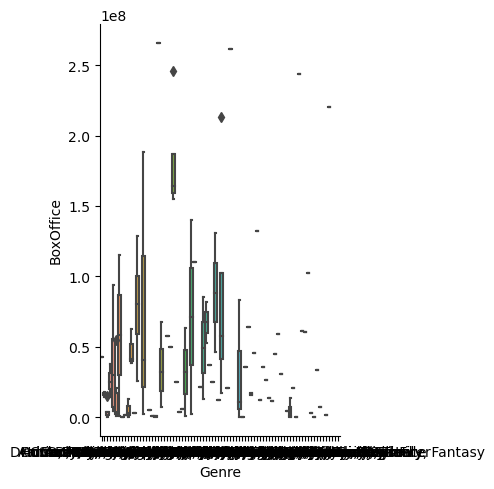

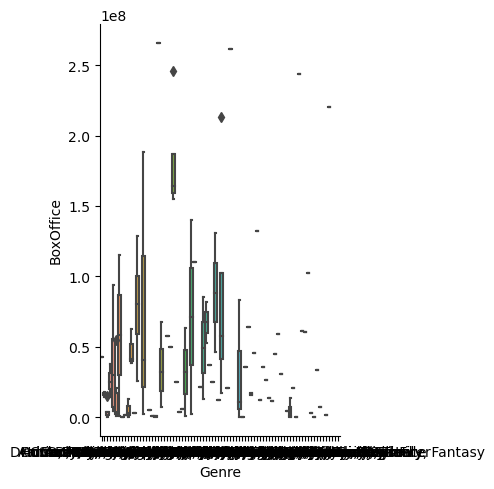

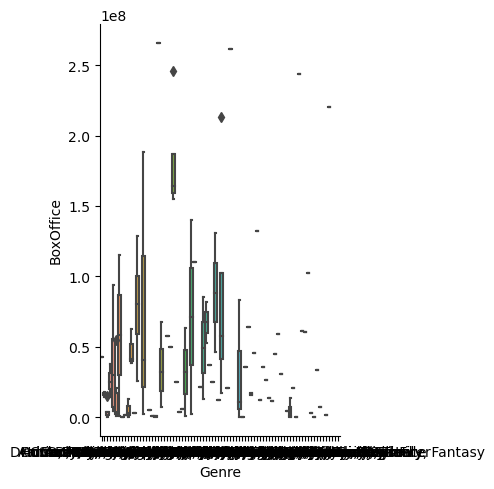

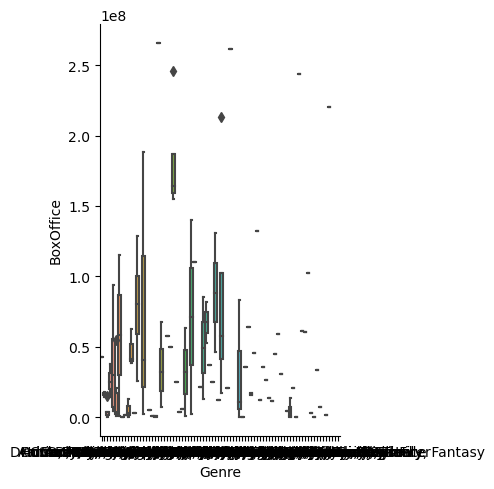

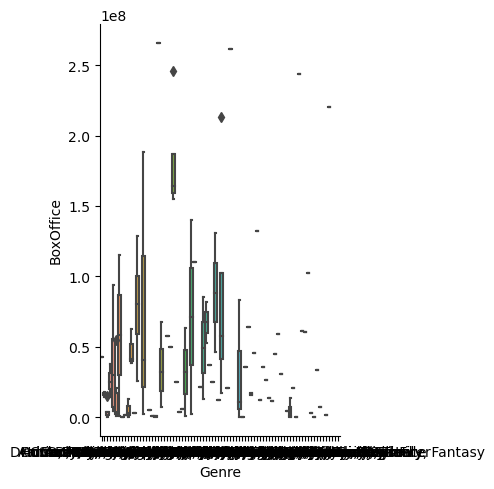

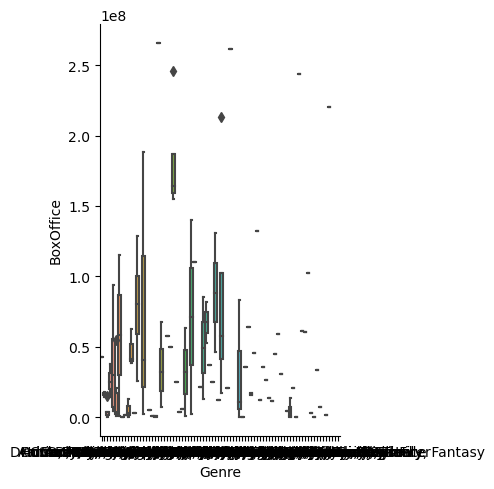

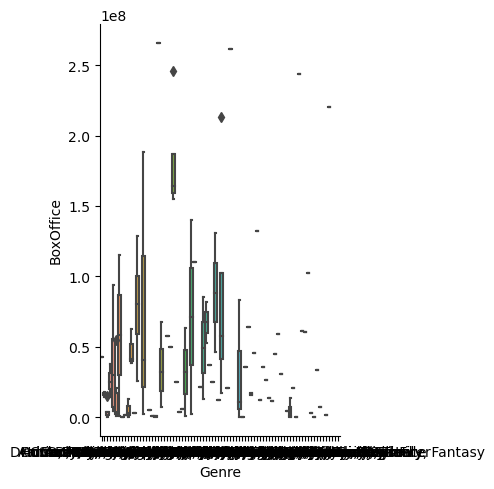

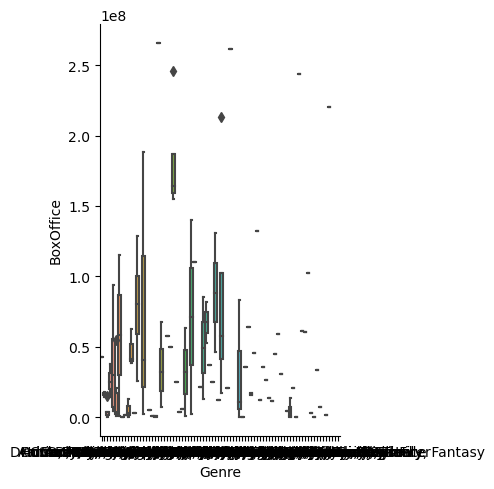

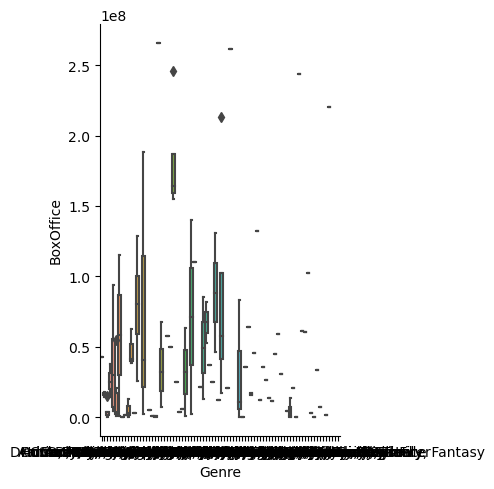

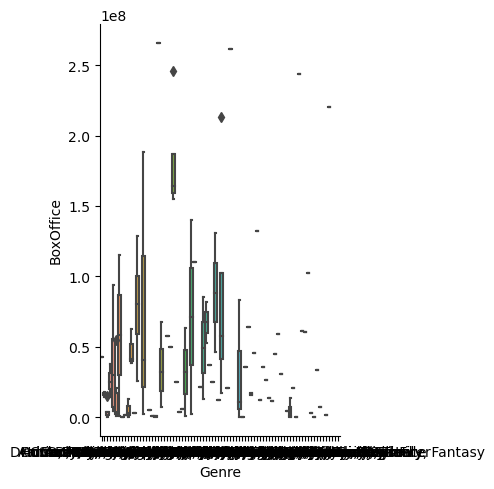

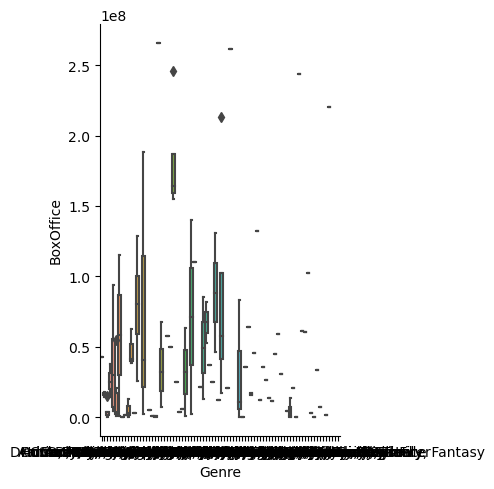

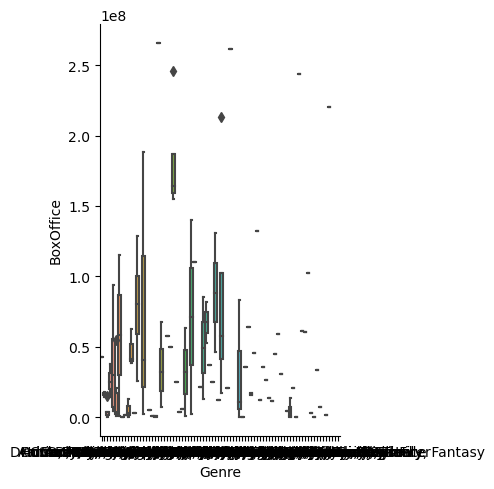

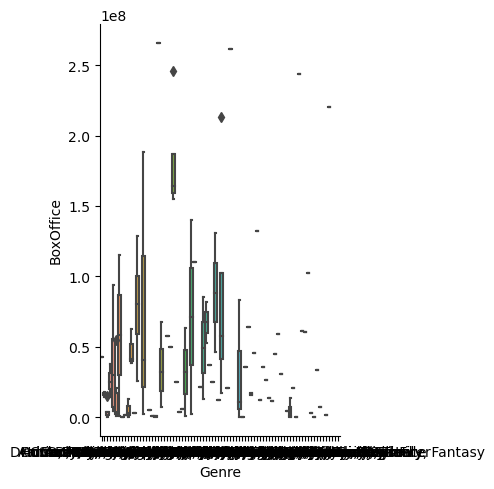

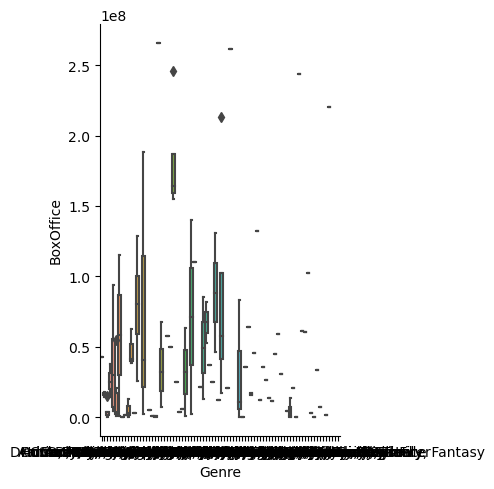

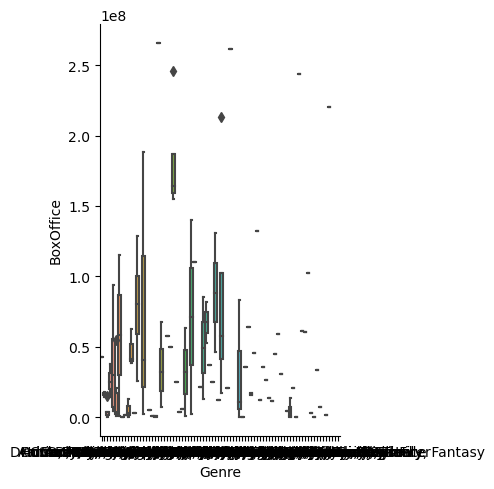

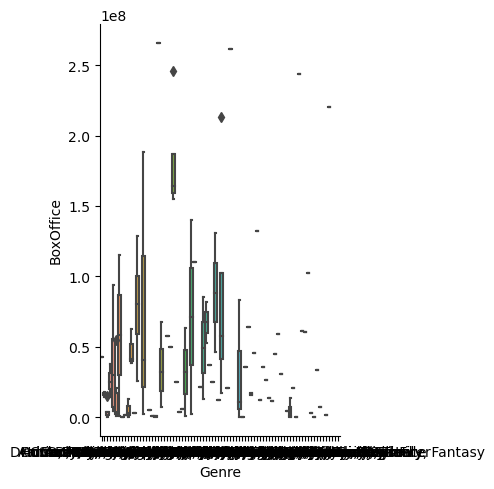

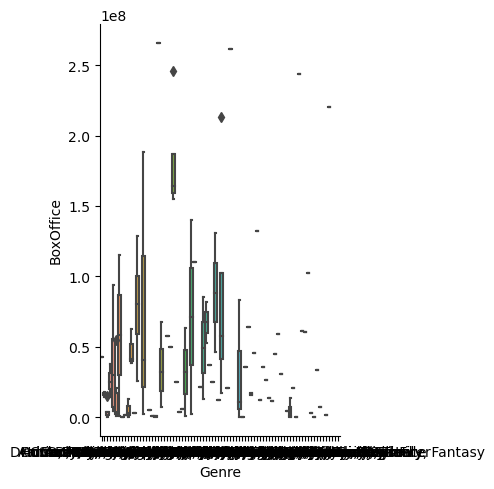

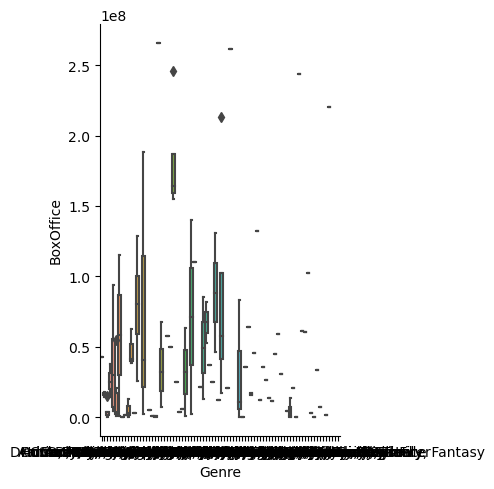

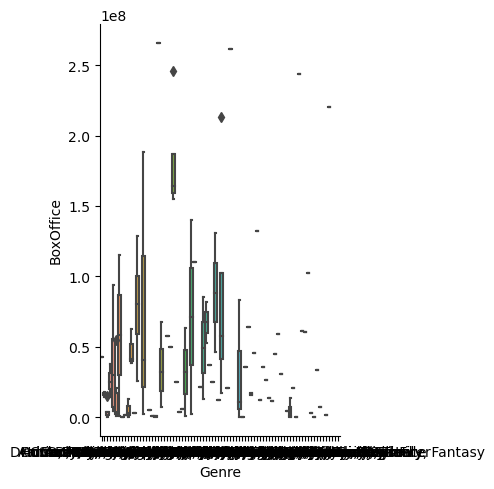

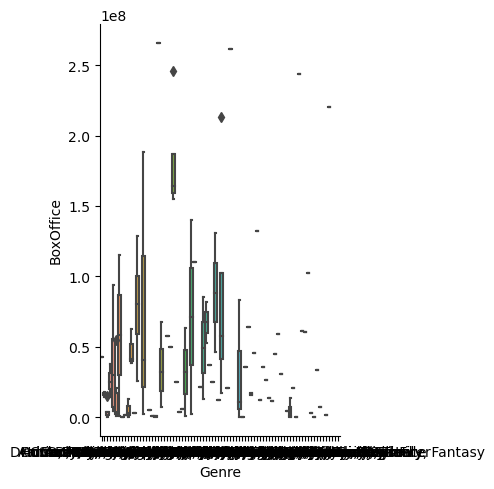

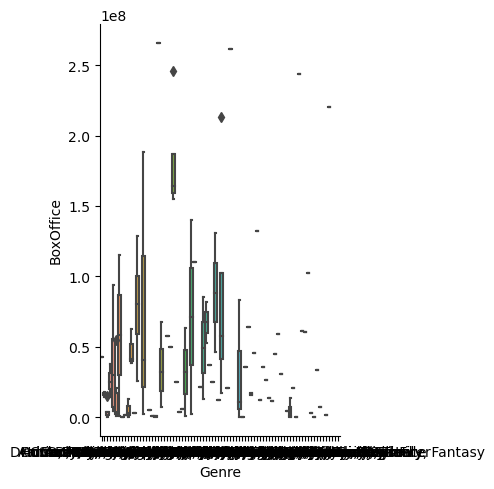

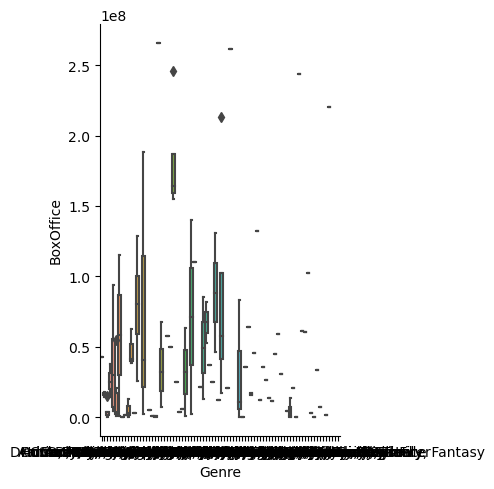

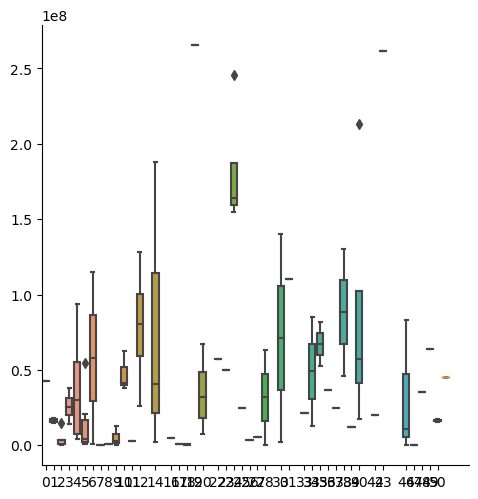

In [232]:
df14 = df_cat.copy()
df14 = df14.merge(df_numeric["BoxOffice"], how='inner', left_index=True, right_index=True)

def t():
    for g in list(df5["Genre"].dropna().unique()):
        sns.catplot(data=df14, x="Genre", y="BoxOffice", kind="box")
        plt.savefig(f"./3/BoxOffice, {g}.png")
    
t()

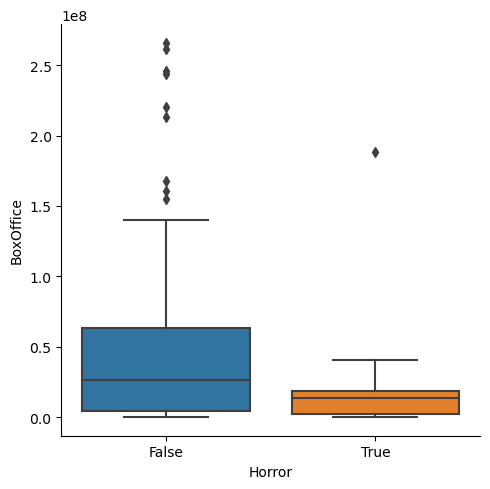

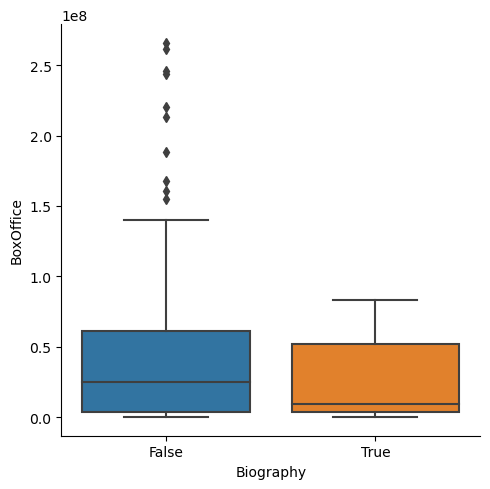

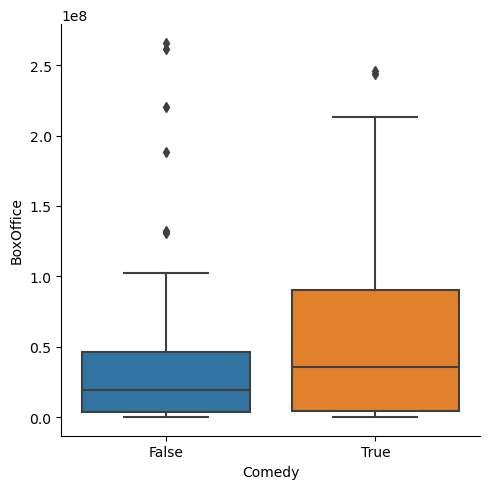

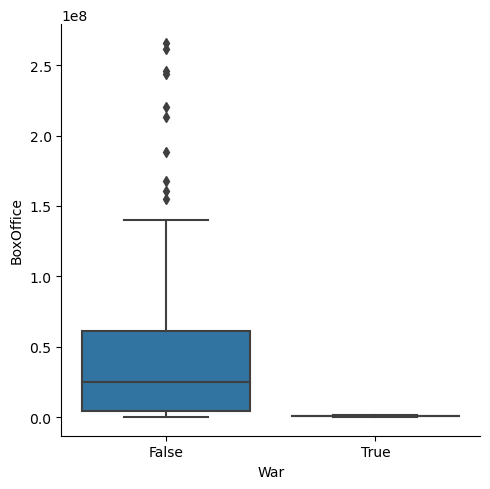

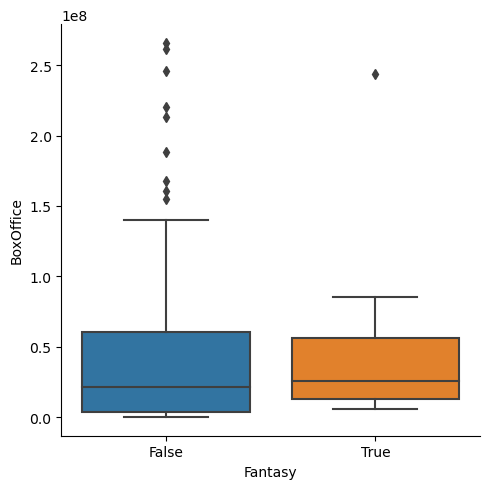

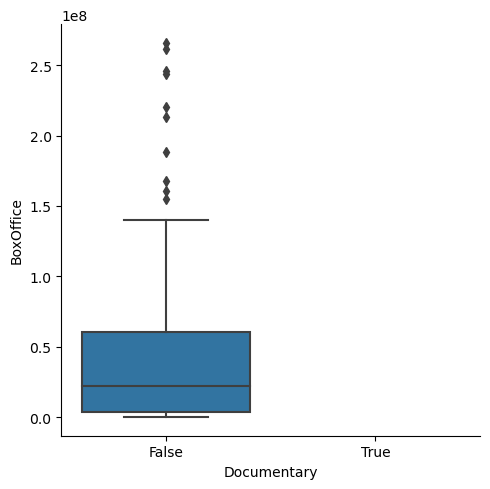

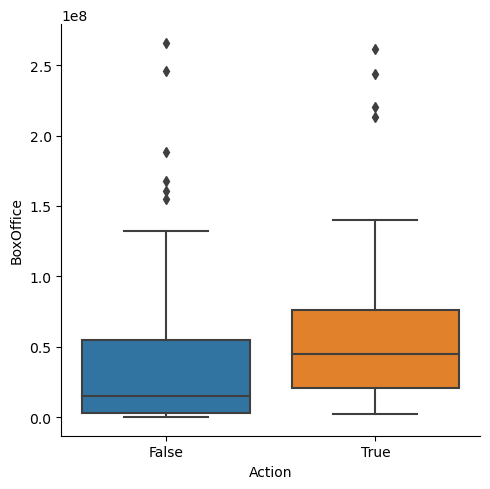

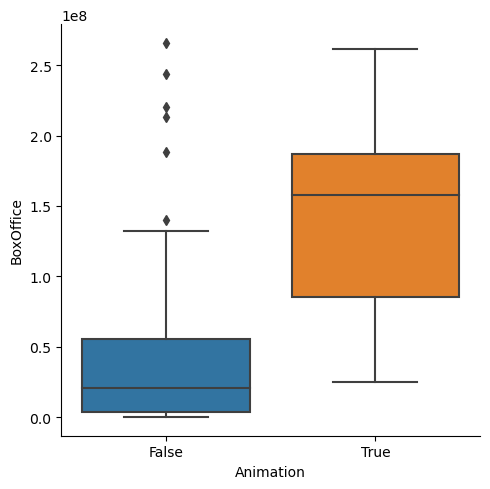

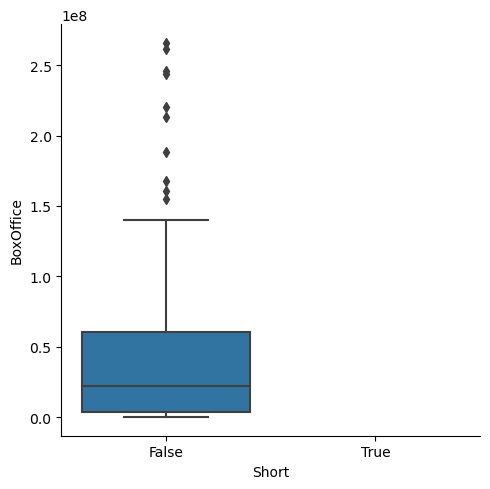

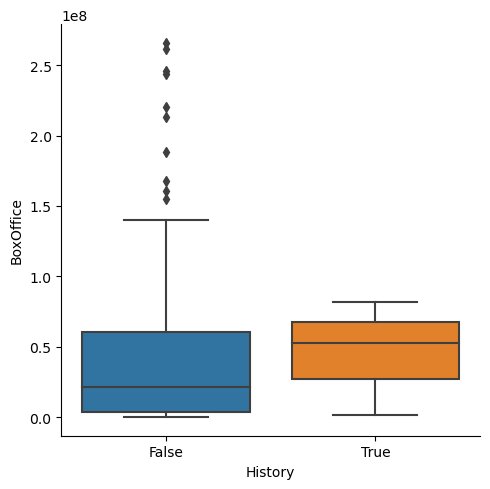

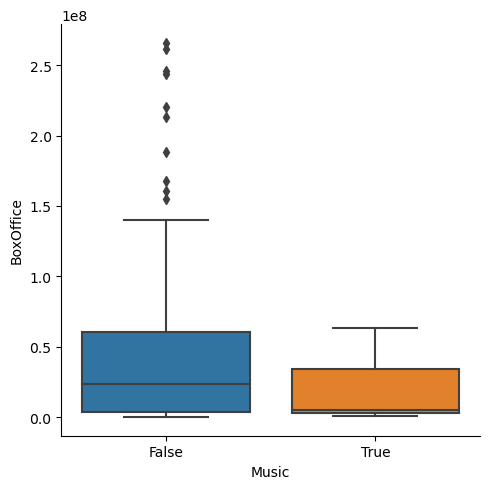

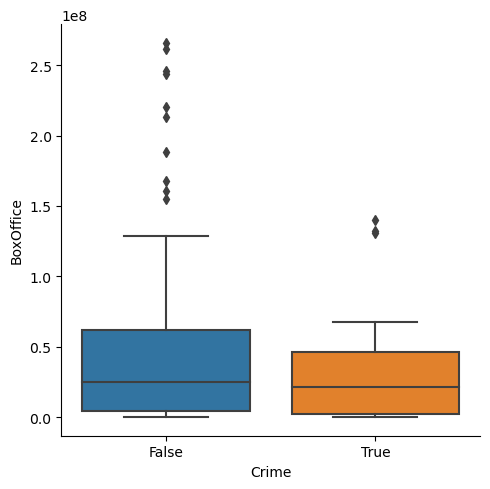

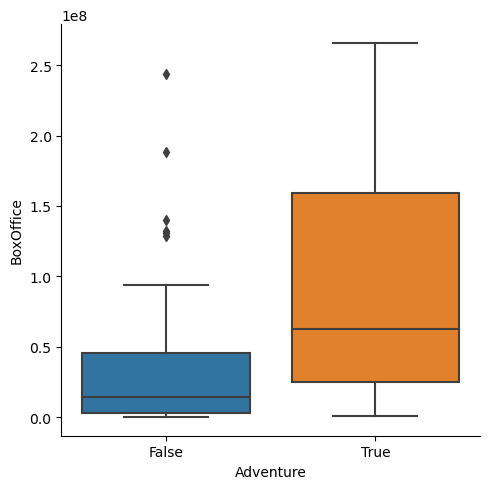

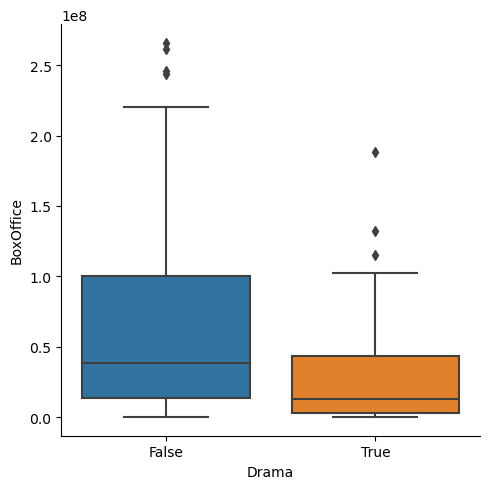

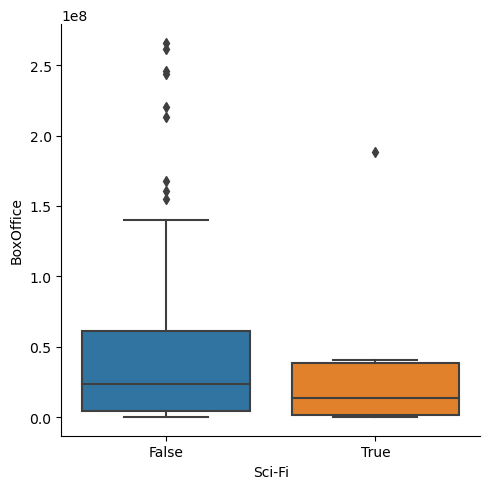

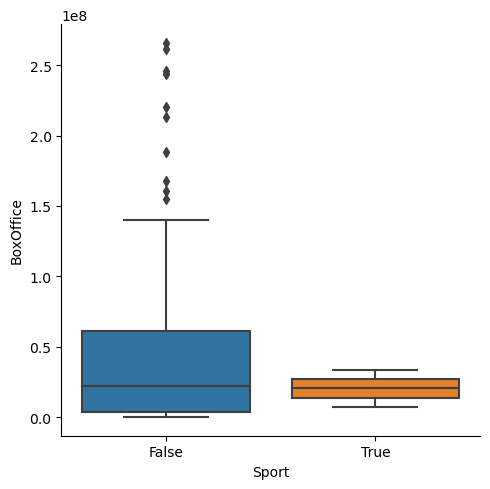

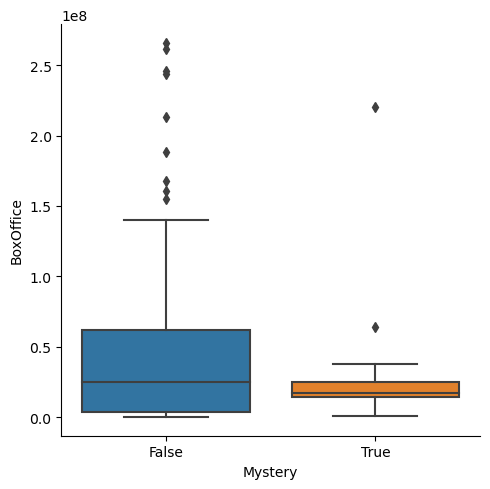

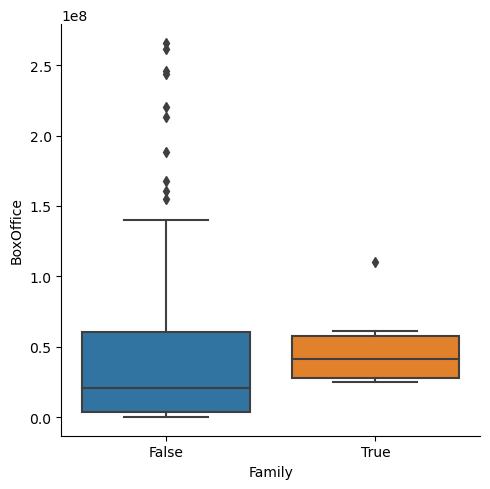

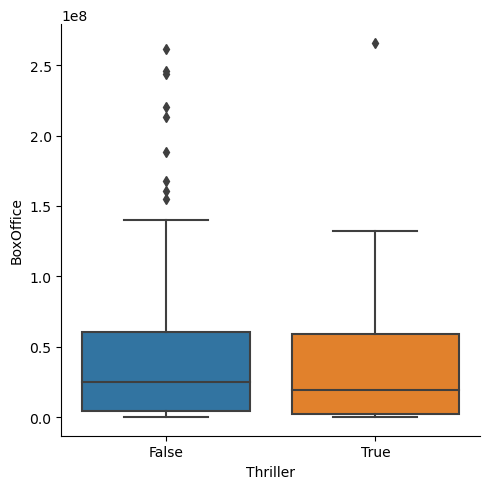

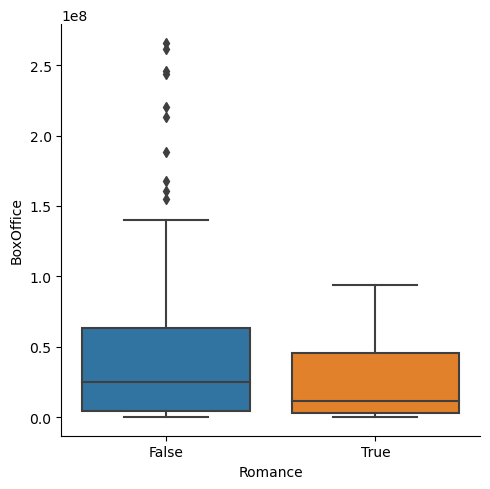

In [200]:
df12 = df_cat.copy()
df12 = df12.merge(df_numeric["BoxOffice"], how='inner', left_index=True, right_index=True)

def t():
    for g in genres:
        sns.catplot(data=df12, x=g, y="BoxOffice", kind="box")
        plt.savefig(f"./1/BoxOffice, {g}.png")
    
t()

In [227]:
df13 = df_cat.copy()
df13 = df13.merge(df_numeric["BoxOffice"], how='inner', left_index=True, right_index=True)

def b():
    for r in rated:
        sns.catplot(data=df13, x=r, y="BoxOffice", kind="box")
        plt.savefig(f"./2/BoxOffice, {r}.png")
    


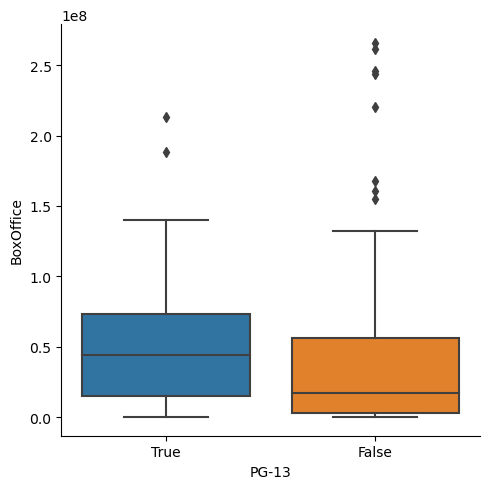

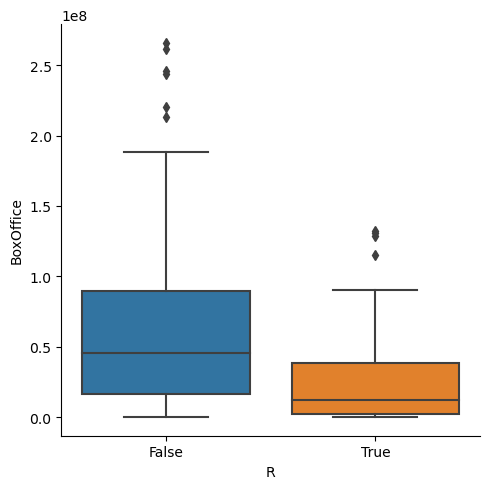

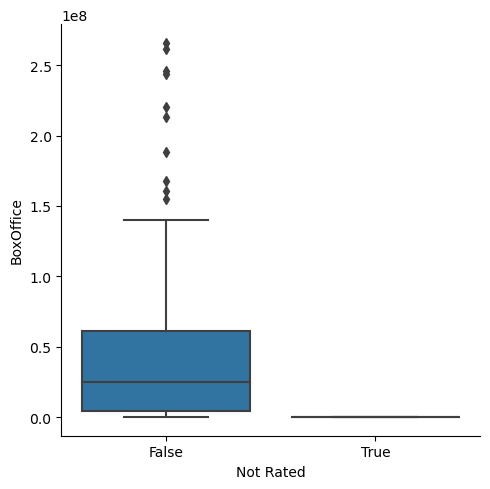

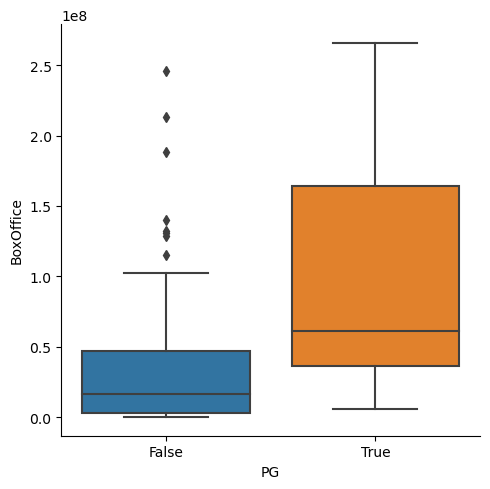

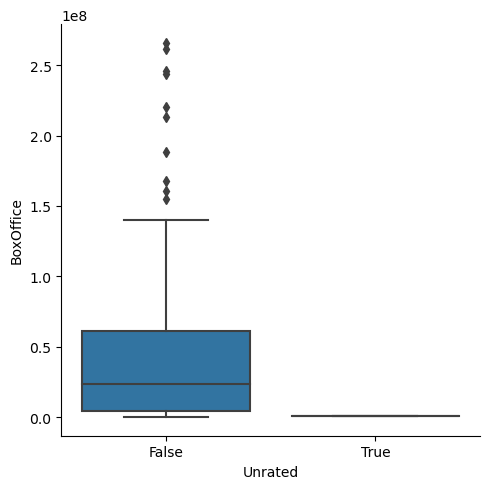

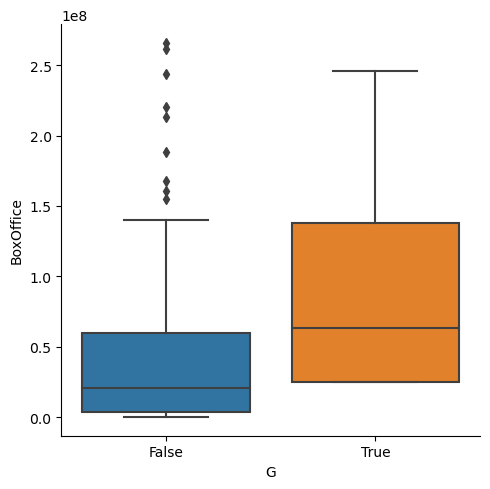

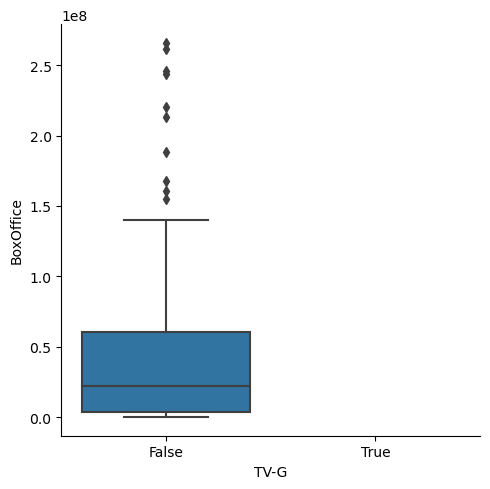

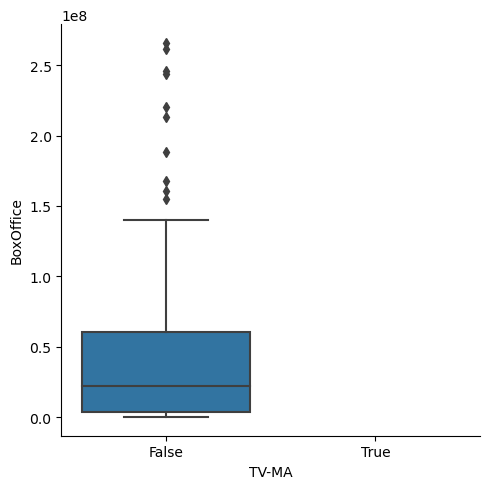

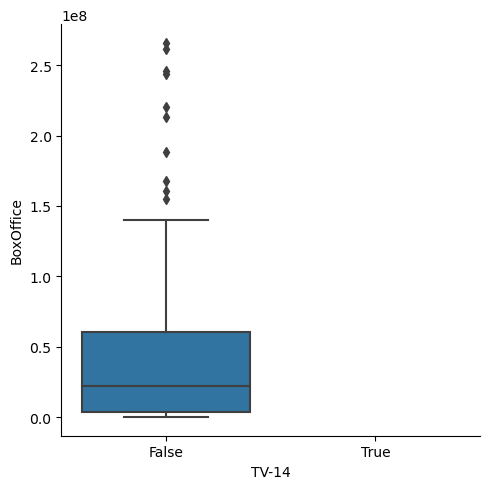

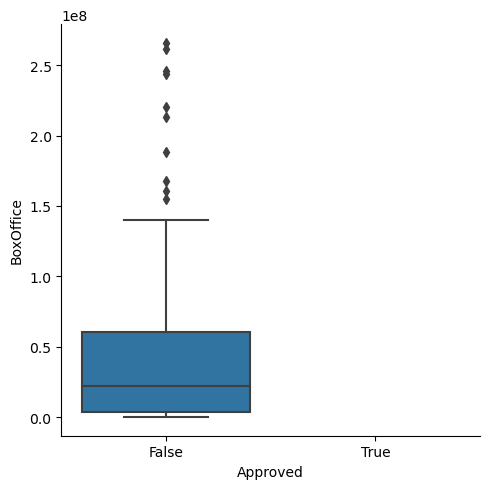

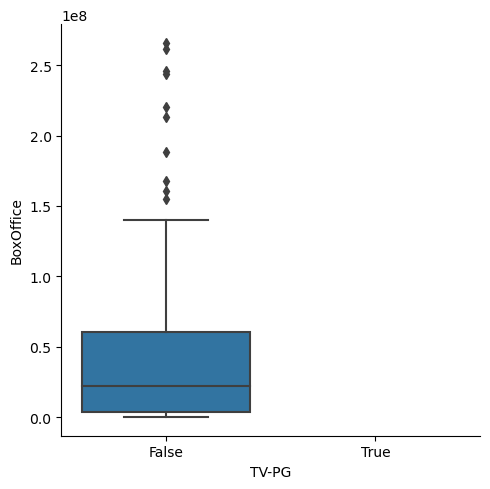

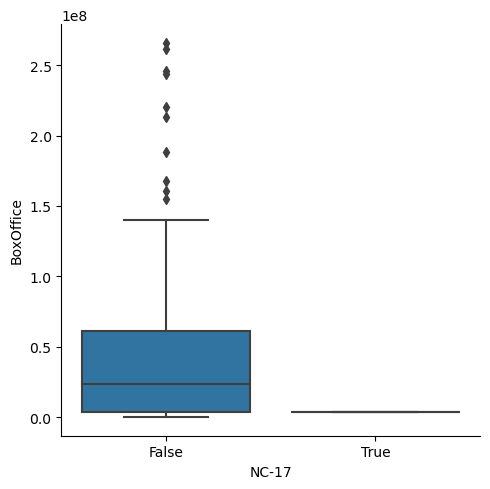

In [228]:
b()

<AxesSubplot:ylabel='Frequency'>

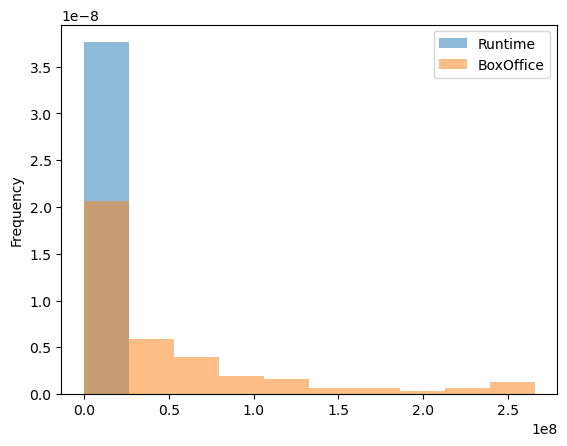

In [41]:
df6.plot.hist(bins=10, alpha=0.5, density=True)

<AxesSubplot:ylabel='Frequency'>

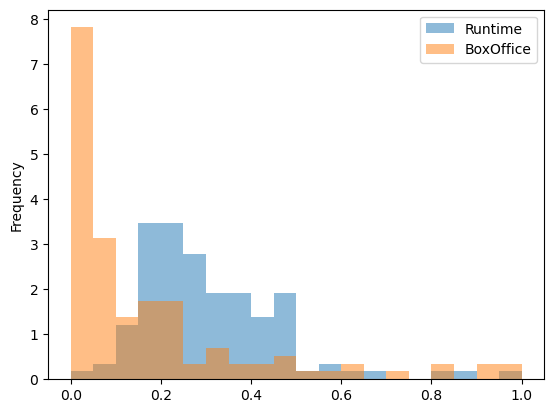

In [44]:
norm_df6=(df6-df6.min())/(df6.max()-df6.min())
norm_df6.plot.hist(bins=20, alpha=0.5, density=True)

In [45]:
# No linear correlation, so try mutual information

from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

X = df6.copy()
y = X.pop("BoxOffice")
make_mi_scores(X, y)

Runtime    0.132701
Name: MI Scores, dtype: float64

In [52]:
#Is there a correlation between IMBD votes and ratings? 

df7 = df4[["imdbVotes", "Metascore", "Rotten Tomatoes", "Metacritic", "imdbRating"]]
df7 = df7.dropna()
df7.corr()


,imdbVotes,Metascore,Rotten Tomatoes,Metacritic,imdbRating
imdbVotes,1.000000,0.390796,0.320871,0.390796,0.566312
Metascore,0.390796,1.000000,0.914302,1.000000,0.781220
Rotten Tomatoes,0.320871,0.914302,1.000000,0.914302,0.739416
Metacritic,0.390796,1.000000,0.914302,1.000000,0.781220
imdbRating,0.566312,0.781220,0.739416,0.781220,1.000000


<AxesSubplot:xlabel='imdbVotes', ylabel='imdbRating'>

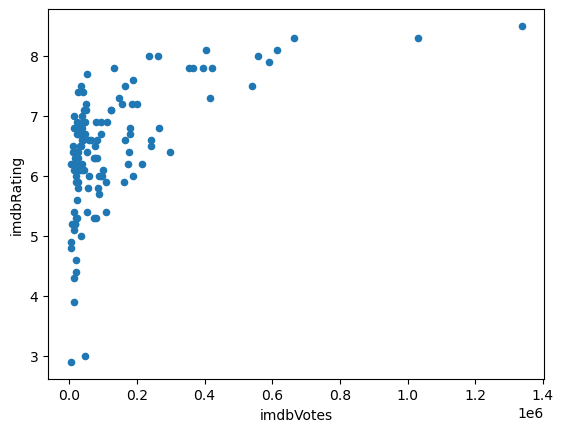

In [54]:
df7.plot.scatter(x="imdbVotes", y="imdbRating")

<AxesSubplot:ylabel='Frequency'>

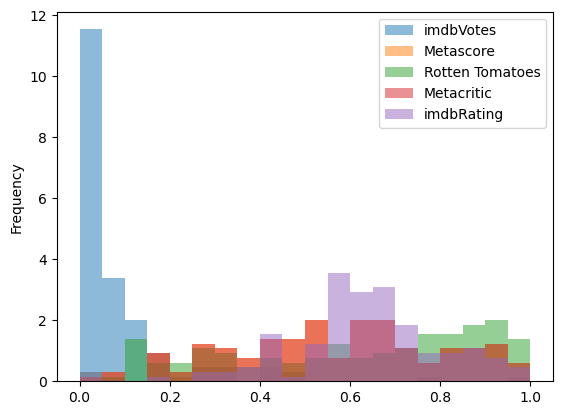

In [56]:
norm_df7=(df7-df7.min())/(df7.max()-df7.min())
norm_df7.plot.hist(bins=20, alpha=0.5, density=True)

In [57]:
df7['log_imdbVotes'] = np.log(df7['imdbVotes'])
df7.corr()

,imdbVotes,Metascore,Rotten Tomatoes,Metacritic,imdbRating,log_imdbVotes
imdbVotes,1.000000,0.390796,0.320871,0.390796,0.566312,0.793335
Metascore,0.390796,1.000000,0.914302,1.000000,0.781220,0.425801
Rotten Tomatoes,0.320871,0.914302,1.000000,0.914302,0.739416,0.332106
Metacritic,0.390796,1.000000,0.914302,1.000000,0.781220,0.425801
imdbRating,0.566312,0.781220,0.739416,0.781220,1.000000,0.631088
log_imdbVotes,0.793335,0.425801,0.332106,0.425801,0.631088,1.000000


<AxesSubplot:ylabel='Frequency'>

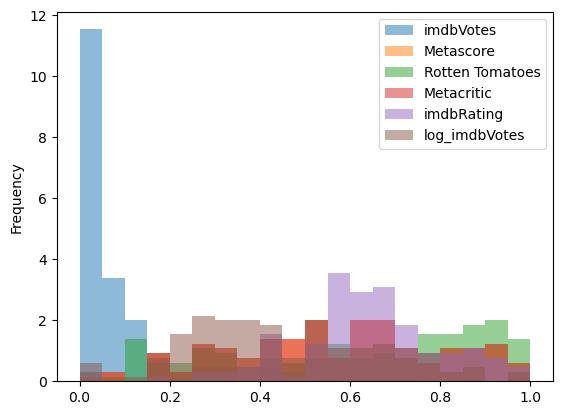

In [58]:
norm_df7=(df7-df7.min())/(df7.max()-df7.min())
norm_df7.plot.hist(bins=20, alpha=0.5, density=True)

In [49]:
X = df7.copy()
y = X.pop("imdbVotes")
make_mi_scores(X, y)

imdbRating         0.259216
Rotten Tomatoes    0.206659
Metascore          0.129914
Metacritic         0.128123
Name: MI Scores, dtype: float64

In [110]:
# Is there a correlation between Google searches (up to and including a year after release) and IMBD rating?

df_trends = pd.read_json("./trends_data.json", orient='table')

df_trends = df_trends.drop("isPartial", axis=1)
df_trends_avg = df_trends.groupby(level=0).mean()


In [111]:
df_trends_std = df_trends.groupby(level=0).std()
df_trends_std

,searches
A Hidden Life,17.809955
A Quiet Place,16.098994
Alpha,7.996700
Anthropoid,20.396707
Ashby,8.386656
...,...
Unknown,12.735030
Welcome to Marwen,16.078193
What the Health,12.894323
Where the Truth Lies,24.321254


In [130]:
df_trends_max = df_trends.groupby(level=0).max()
df_trends_min = df_trends.groupby(level=0).min()

In [131]:
df_trends_stats = pd.concat([df_trends_avg, df_trends_std, df_trends_max, df_trends_min], axis=1)
df_trends_stats.columns = ["avg", "std", "max", "min"]
df_trends_stats[df_trends_stats["max"] < 100]

,avg,std,max,min


<AxesSubplot:xlabel='avg', ylabel='std'>

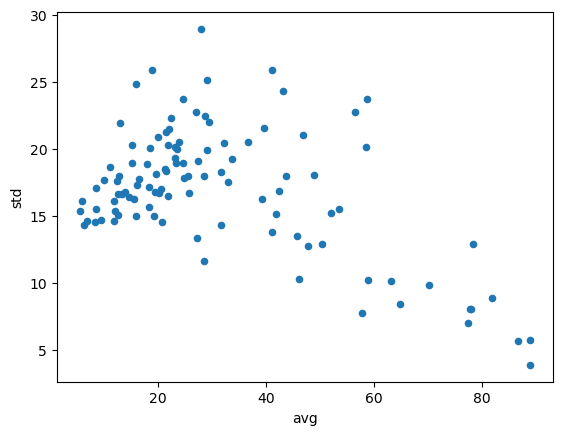

In [113]:
df_trends_stats.plot.scatter(x='avg', y='std')

In [114]:
df_trends_stats = df_trends_stats.merge(df7, how='left', left_index=True, right_index=True)
df_trends_stats = df_trends_stats.dropna()
df_trends_stats

,avg,std,imdbVotes,Metascore,Rotten Tomatoes,Metacritic,imdbRating,log_imdbVotes
A Hidden Life,24.811321,17.809955,25384.0,78.0,0.82,0.78,7.4,10.141874
A Quiet Place,11.865385,16.098994,539598.0,82.0,0.96,0.82,7.5,13.198580
Alpha,77.884615,7.996700,63790.0,63.0,0.80,0.63,6.6,11.063352
Anthropoid,32.115385,20.396707,50250.0,59.0,0.67,0.59,7.2,10.824766
Ashby,64.830189,8.386656,15880.0,46.0,0.52,0.46,6.4,9.672816
...,...,...,...,...,...,...,...,...
The Weather Man,26.923077,22.769817,81389.0,61.0,0.59,0.61,6.6,11.306995
Twisted,81.886792,8.863626,22435.0,26.0,0.02,0.26,5.3,10.018378
Unknown,47.769231,12.735030,263916.0,56.0,0.55,0.56,6.8,12.483386
Welcome to Marwen,5.961538,16.078193,24654.0,40.0,0.34,0.40,6.2,10.112694


<AxesSubplot:xlabel='avg', ylabel='imdbRating'>

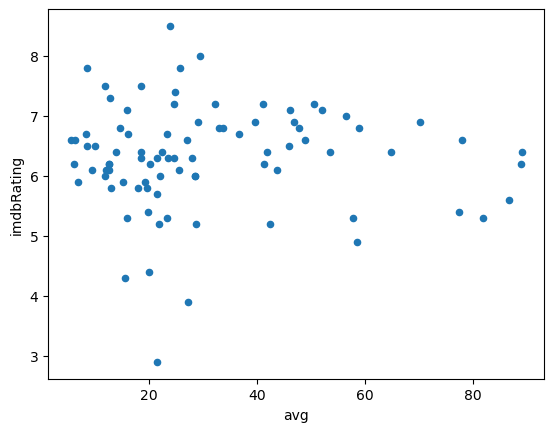

In [118]:
df8 = df_trends_stats.copy()
df8.plot.scatter(x='avg', y='imdbRating')

<AxesSubplot:ylabel='Frequency'>

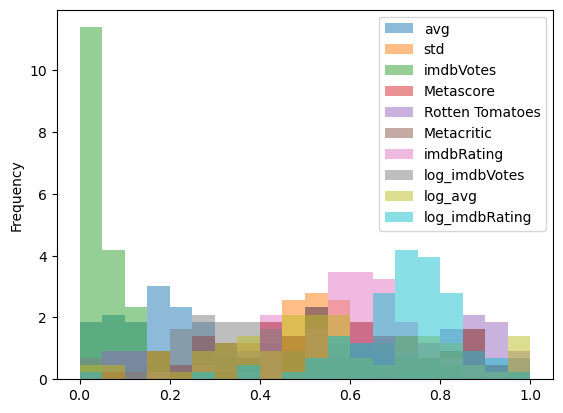

In [143]:
norm_df8=(df8-df8.min())/(df8.max()-df8.min())
norm_df8.plot.hist(bins=20, alpha=0.5, density=True)

<AxesSubplot:xlabel='log_avg', ylabel='log_imdbRating'>

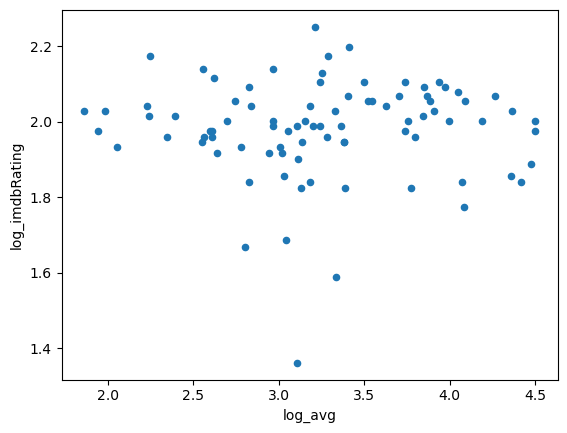

In [144]:
df8["log_avg"] = np.log(df8['avg'])
df8["log_imdbRating"] = np.log(df8['imdbRating'])
df8.plot.scatter(x='log_avg', y='log_imdbRating')

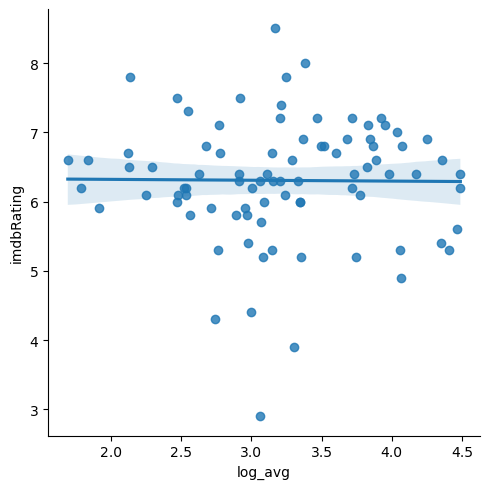

In [137]:
sns.lmplot(data=df8, x='log_avg', y='imdbRating')

<AxesSubplot:xlabel='avg', ylabel='BoxOffice'>

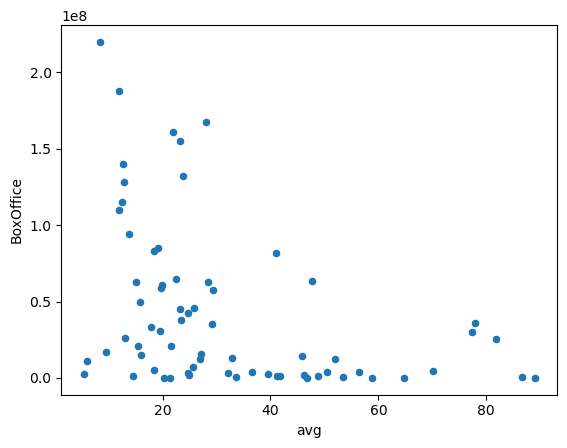

In [149]:
# Is there a correlation between Google searches (up to and including a year after release) and box office earnings?

df9 = df8.copy()
df9 = df9.merge(df4['BoxOffice'], how='left', left_index=True, right_index=True)
df9.plot.scatter(x='avg', y='BoxOffice')

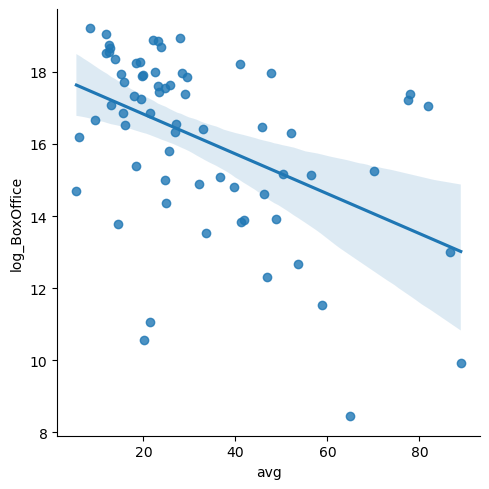

In [155]:
df9['log_BoxOffice'] = np.log(df9['BoxOffice'])
sns.lmplot(data=df9, x='avg', y='log_BoxOffice')

In [162]:
df10 = df9[["avg", "std", "log_BoxOffice","log_avg", "BoxOffice"]]
df10.corr()

,avg,std,log_BoxOffice,log_avg,BoxOffice
avg,1.000000,-0.534831,-0.469987,0.940987,-0.400036
std,-0.534831,1.000000,0.316325,-0.333774,0.216649
log_BoxOffice,-0.469987,0.316325,1.000000,-0.445470,0.711622
log_avg,0.940987,-0.333774,-0.445470,1.000000,-0.419670
BoxOffice,-0.400036,0.216649,0.711622,-0.419670,1.000000


In [165]:
X = df10.copy()
X = X.dropna()
y = X.pop("BoxOffice")
make_mi_scores(X, y)

log_BoxOffice    1.753766
log_avg          0.166444
avg              0.165973
std              0.000000
Name: MI Scores, dtype: float64

<AxesSubplot:xlabel='log_min', ylabel='log_BoxOffice'>

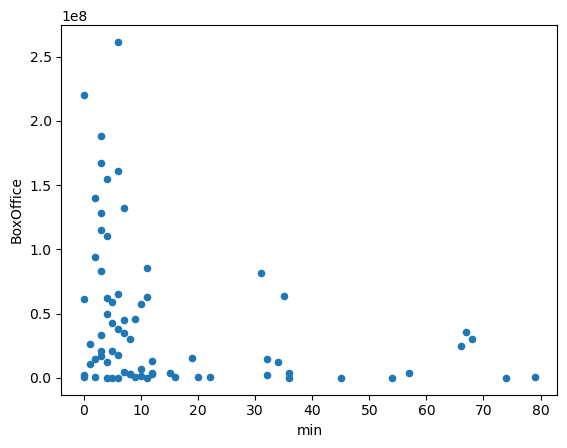

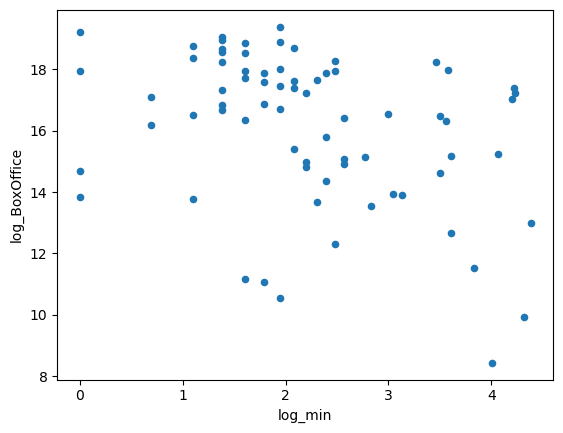

In [176]:
df11 = df_trends_stats.copy()
df11 = df11.merge(df4['BoxOffice'], how='left', left_index=True, right_index=True)
df11.plot.scatter(x='min', y='BoxOffice')
df11['log_min'] = np.log(df11['min'] + 1)
df11['log_BoxOffice'] = np.log(df11['BoxOffice'] + 1)
df11.plot.scatter(x='log_min', y='log_BoxOffice')

In [325]:
df_numeric2 = df_numeric.drop("searches_max", axis=1)
df_numeric2["log_imdbVotes"] = np.log(df_numeric["imdbVotes"] + 1)
df_numeric2["log_BoxOffice"] = np.log(df_numeric["BoxOffice"] + 1)
df_numeric2["searches_norm_avg"] = df_numeric["searches_avg"] / df_numeric["searches_std"]

<AxesSubplot:>

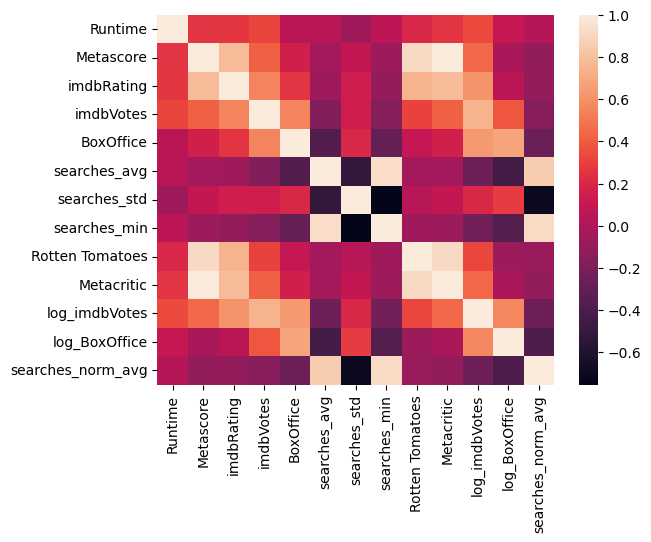

In [326]:
corr = df_numeric2.corr()

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

<AxesSubplot:>

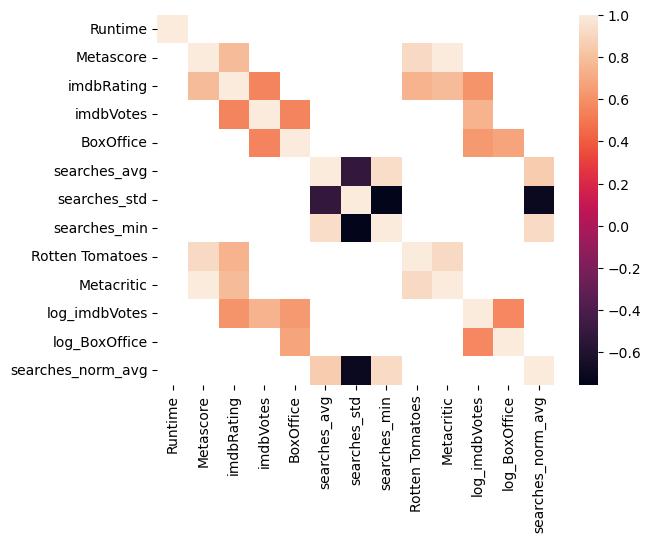

In [327]:
threshold = 0.5
corr_filtered = corr.copy()
corr_filtered = corr_filtered[abs(corr_filtered) > threshold]


sns.heatmap(corr_filtered, 
        xticklabels=corr_filtered.columns,
        yticklabels=corr_filtered.columns)

In [351]:
# Try to combine ratings and use PCA

df_ratings = df_numeric[["Metascore", "imdbRating", "Rotten Tomatoes"]]
df_ratings = df_ratings.dropna()


In [370]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

pca = PCA(n_components=3)
scaler = MinMaxScaler()
# pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=2))])
# pipeline.fit_transform(data)
df_ratings_n = pd.DataFrame(scaler.fit_transform(df_ratings))
# df_ratings_n = df_ratings_n.set_index(df_ratings.index)
pca.fit(df_ratings_n)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.90200885 0.06747544 0.03051571]
[4.39688481 1.20257606 0.80872601]


In [371]:
#Choose the number of components to include in your model by adding the explained variance ratio of each component until you reach a total of around 0.8 or 80% to avoid overfitting.
# First singular value about twice the magnitude of others, hence only use one component
pca = PCA(n_components=1)
pca.fit(df_ratings_n)
df_ratings_t = pd.DataFrame(pca.transform(df_ratings_n))
df_ratings_t = df_ratings_t.set_index(df_ratings.index)
df_ratings_t = df_ratings_t.rename({0: "agg_rating"}, axis=1)
df_ratings_t

,agg_rating
Title,
The Age of Adaline,0.026164
Black Christmas,-0.176976
London,0.558121
Twisted,0.705445
Friends with Kids,-0.013173
...,...
The Phantom,0.247719
A Hidden Life,-0.364287
National Treasure: Book of Secrets,0.230733


In [387]:
df_numeric3 = df_numeric2.merge(df_ratings_t, how='inner', left_index=True, right_index=True)
df_numeric3 = df_numeric3.dropna()

<AxesSubplot:>

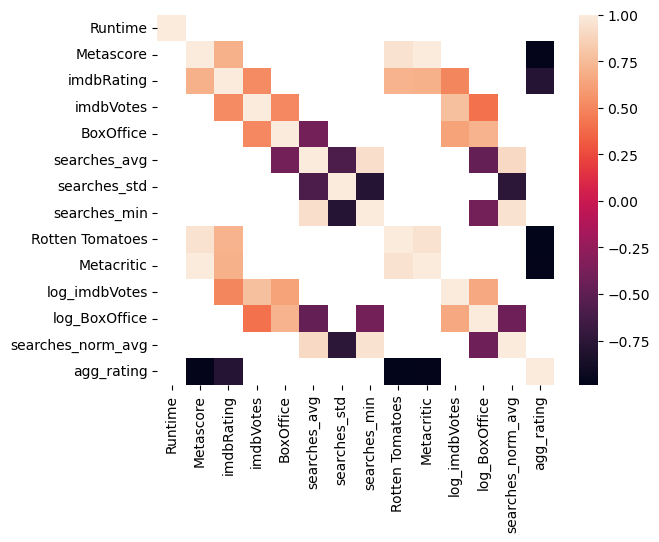

In [388]:
threshold = 0.4
corr_filtered = df_numeric3.copy().corr()
corr_filtered = corr_filtered[abs(corr_filtered) > threshold]

sns.heatmap(corr_filtered,
        xticklabels=corr_filtered.columns,
        yticklabels=corr_filtered.columns)

In [412]:
# Try XGBBoost
import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

X = df_numeric3.copy()
X = X.drop("log_BoxOffice", axis=1)
y = X.pop("BoxOffice")

model = xgboost.XGBRegressor()
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: -33941588.283 (8725265.488)


In [420]:
from sklearn.linear_model import LinearRegression, Ridge,Lasso 
from sklearn.preprocessing import MinMaxScaler

scaler2 = MinMaxScaler()
X = df_numeric3.copy()

X_n = pd.DataFrame(scaler2.fit_transform(X), columns=cols)
y_n = X_n.pop("BoxOffice")

reg = LinearRegression().fit(X_n, y_n)
reg.score(X_n, y_n)


0.5366319482668689

In [425]:
reg = Ridge(alpha=.5).fit(X_n, y_n)
reg.score(X_n, y_n)

0.5024617286049058

In [429]:
reg = Lasso(alpha=0.001).fit(X_n, y_n)
reg.score(X_n, y_n)

0.5140995156766308

In [435]:
from sklearn import linear_model

reg = linear_model.BayesianRidge().fit(X_n, y_n)
reg.score(X_n, y_n)

0.5069004883846211

In [444]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_n, y_n, test_size=0.2, random_state=42)

dt = DecisionTreeRegressor().fit(X_train, y_train)



-0.8169682033053056

In [445]:
dt.score(X_test, y_test)


-0.8169682033053056

In [466]:
pca2 = PCA(n_components=12)
X_nt = pd.DataFrame(pca2.fit_transform(X_n))

reg = LinearRegression().fit(X_nt, y_n)
reg.score(X_nt, y_n)


0.536631948266869